# Base Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from shutil import copyfile

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch_snippets import Report
import time

2021-07-03 20:31:57.772 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-07-03 20:31:58.673 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [3]:
base_model_path = '../src/base-model/'

module_path = os.path.abspath(os.path.join('../src/base-model/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils
import rcnn

In [4]:
## sample of 135 images 
## resized by a factor of 4 from 2048x1024 to 512x256 
imgs_path = '../data/sample-dataset/'

In [5]:
## load annotations of 135 images
anno_dict = np.load('../data/anno-big.npy', allow_pickle='TRUE').item()
imgs_person = list(anno_dict.keys())
len(imgs_person)

135

In [6]:
## resize annotations by factor SCALE
SCALE = 4
res_anno_dict = {}
for img_name in imgs_person:
    res_bboxes = []
    for bbox in anno_dict[img_name]:
        res_bbox = bbox / SCALE
        res_bbox = res_bbox.astype('int32')
        res_bboxes.append(res_bbox)
    res_anno_dict[img_name] = res_bboxes
anno_dict = res_anno_dict # keep only the resized dict

In [7]:
## get simple regions
regions = utils.get_simple_regions(SCALE)

In [8]:
i = 0
img_name = imgs_person[i]
img_path = imgs_path + img_name
img = Image.open(img_path)
bboxes = anno_dict[img_name]

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]

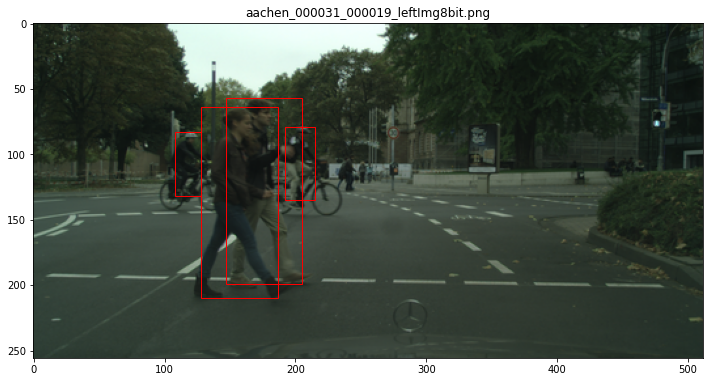

In [10]:
fig, ax = plt.subplots()
ax.imshow(img)

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

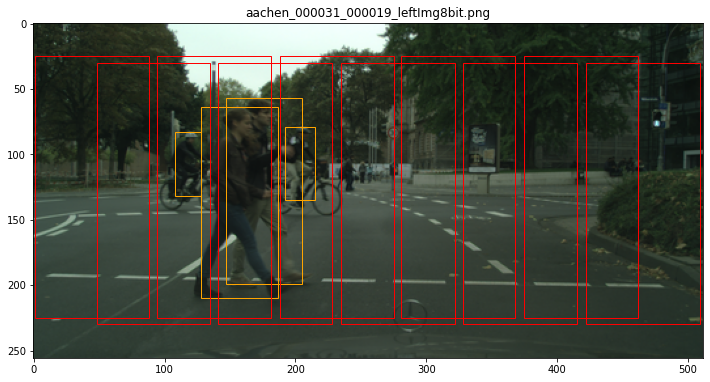

In [11]:
fig, ax = plt.subplots()
ax.imshow(img)

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)

for bbox in regions:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
plt.title(img_name)
plt.show()

In [12]:
img_np = np.array(img)
H, W = img_np.shape[:2]

In [13]:
H,W

(256, 512)

## Prepare data

In [14]:
all_img_names, all_labels, all_diffs, all_rois, all_bboxes = utils.get_data(
    imgs_person, anno_dict, regions, W, H)

In [15]:
len(all_img_names), len(all_labels)

(135, 135)

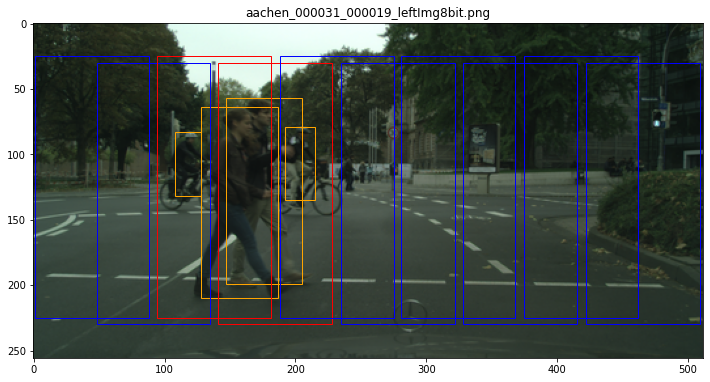

In [16]:
## check results
i = 0
img_name = all_img_names[i]
bboxes = all_bboxes[i]

img_path = imgs_path + img_name
img = Image.open(img_path)

fig, ax = plt.subplots()
ax.imshow(img)

labels = all_labels[i]
colors = ['b', 'r']

for i, bbox in enumerate(bboxes):
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)

for i, bbox in enumerate(regions):
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor=colors[labels[i]], facecolor='none')
    ax.add_patch(rect)
    
plt.title(img_name)
plt.show()

In [17]:
img_region = np.array([W, H, W, H]) # for scaling
diffs0 = all_diffs[0] * img_region
diffs0

array([[-146.,  -32.,   29.,   58.],
       [ -60.,  -53.,   67.,  151.],
       [ -34.,  -39.,   28.,   54.],
       [  -6.,  -27.,   29.,   58.],
       [  41.,  -32.,   29.,   58.],
       [  88.,  -27.,   29.,   58.],
       [ 134.,  -32.,   29.,   58.],
       [ 181.,  -27.,   29.,   58.],
       [ 228.,  -32.,   29.,   58.],
       [ 275.,  -27.,   29.,   58.]])

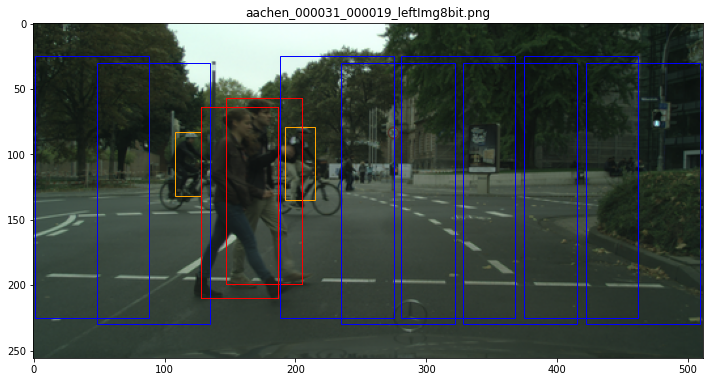

In [18]:
i = 0
img_name = all_img_names[i]
bboxes = all_bboxes[i]
img_path = imgs_path + img_name
img = Image.open(img_path)

fig, ax = plt.subplots()
ax.imshow(img);

labels = all_labels[i]
colors = ['b', 'r']

# bbox = [x, y, w, h]
for i, bbox in enumerate(bboxes):
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)

for i, bbox in enumerate(regions):
    if labels[i] == 1:
        bbox = bbox - diffs0[i] # add the diffs
    
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor=colors[labels[i]], facecolor='none')
    ax.add_patch(rect)
    
plt.title(img_name)
plt.show()

## Prepare train and test sets

In [19]:
img_paths = [(imgs_path + img_name) for img_name in all_img_names]
n_train = 8 * len(img_paths) // 10
n_train

108

In [20]:
## img_paths, rois, labels, diffs, bboxes
train_set = rcnn.Dataset(
    img_paths[:n_train], all_rois[:n_train], all_labels[:n_train], 
    all_diffs[:n_train], all_bboxes[:n_train])

test_set = rcnn.Dataset(
    img_paths[n_train:], all_rois[n_train:], all_labels[n_train:], 
    all_diffs[n_train:], all_bboxes[n_train:])

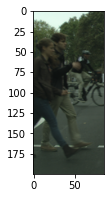

1


In [21]:
## check the results
image, crops, roi_bboxes, labels, diffs, bboxes, img_path = train_set[0]


plt.rcParams['figure.figsize'] = [5, 3]
fig, ax = plt.subplots()
ax.imshow(crops[3])
plt.show()

print(labels[3])

In [22]:
train_loader = DataLoader(
    train_set, batch_size=2, collate_fn=train_set.collate_fn, drop_last=True)

In [23]:
test_loader = DataLoader(
    test_set, batch_size=2, collate_fn=test_set.collate_fn, drop_last=True)

## Define the backbone

In [24]:
backbone = utils.get_backbone()

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [26]:
backbone.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train the model

In [27]:
model = rcnn.BaseModel(backbone).to(device)
criterion = model.calc_loss
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [28]:
n_epochs = 5

## log for plot training and validation metrics
log = Report(n_epochs)
tstart = time.time()
for epoch in range(n_epochs):

    _n = len(train_loader)
    for i, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = rcnn.train_batch(
            inputs, model, optimizer, criterion)
        pos = (epoch + (i + 1)/_n)
        log.record(pos, 
                   trn_loss=loss.item(), 
                   trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), 
                   end='\r')
        
    _n = len(test_loader)
    for i, inputs in enumerate(test_loader):
        _clss, _diffs, loss, \
        loc_loss, regr_loss, accs = rcnn.validate_batch(
            inputs, model, criterion)
        pos = (epoch + (i + 1)/_n)
        log.record(
            pos, 
            val_loss=loss.item(), 
            val_loc_loss=loc_loss, 
            val_regr_loss=regr_loss, 
            val_acc=accs.mean(), 
            end='\r')

tend = time.time()

EPOCH: 5.000	val_loss: 0.034	val_loc_loss: 0.034	val_regr_loss: 0.000	val_acc: 1.000	(872.34s - 0.00s remaining))))

***Training on 8th Gen Intel i5 cpu (i5-9500T CPU @ 2.20GHz) took about:***

In [29]:
print('Time elapsed = %.2f min' % ((tend - tstart)/60))

Time elapsed = 14.54 min


100%|██████████| 106/106 [00:00<00:00, 3715.93it/s]


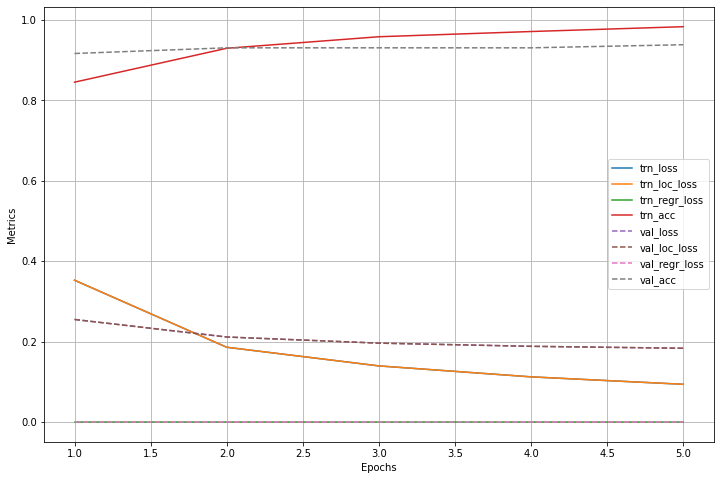

In [30]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
log.plot_epochs(ax=ax)

In [31]:
def detect(img, scale=4, show=True):
    np_image = np.array(img)
    
    ## reverse the code from before
    regions = utils.get_simple_regions(scale)
    input = []
    crops = []
    for region in regions:
        x, y, w, h = region
        x0, y0, x1, y1 = x, y, x + w, y + h
        crop = np_image[y0:y1, x0:x1]
        crops.append(crop)
    
    newsize = (224, 224)
    crops = [Image.fromarray(crop, 'RGB') for crop in crops]    
    crops = [crop.resize(newsize) for crop in crops]
    crops = [utils.preprocess_image(crop)[None] for crop in crops]
    
    input = torch.cat(crops).to(device)
    with torch.no_grad():
        model.eval()
        probs, diffs = model(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, classes = torch.max(probs, -1)
    
    regions = np.array(regions)
    confs, classes, probs, diffs = [
        tensor.detach().cpu().numpy() for tensor in [confs, classes, probs, diffs]]
    
    ## TODO: use nms to lower the recall
    if show:
        ## adding predicted diffs
        detected_bboxes = (regions + diffs).astype(np.uint16) 

        fig, ax = plt.subplots()
        plt.title('Pedestrians detected')
        ax.imshow(img)

        classes = classes.tolist()
        for i, bbox in enumerate(detected_bboxes):
            if classes[i] == 1:
                rect = patches.Rectangle(
                    (bbox[0], bbox[1]), bbox[2], bbox[3], 
                    linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        plt.show()
    
    return {'confs': confs, 'classes': classes}

In [32]:
def detect_wrap(i):
    img_name = all_img_names[i]
    img_path = imgs_path + img_name
    img = Image.open(img_path)
    return detect(img)

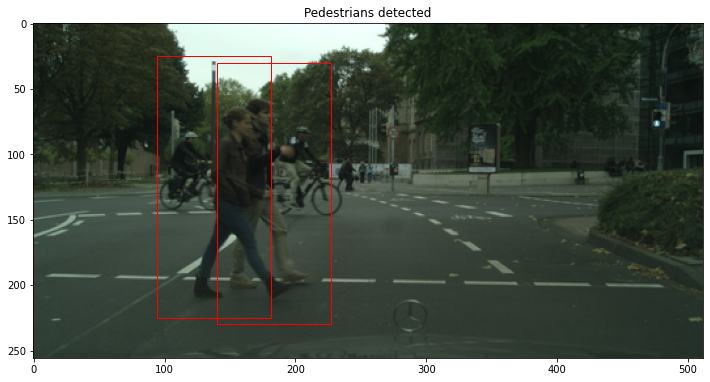

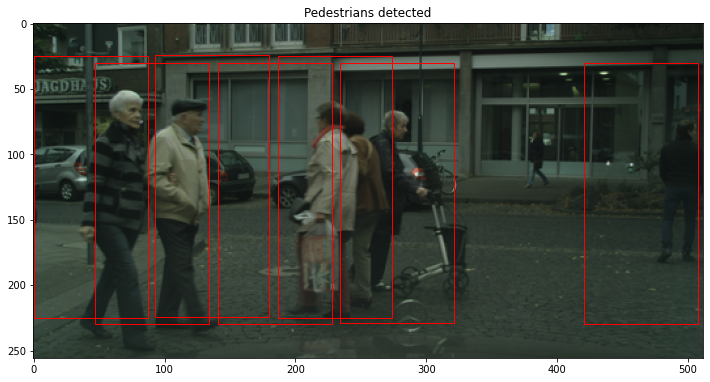

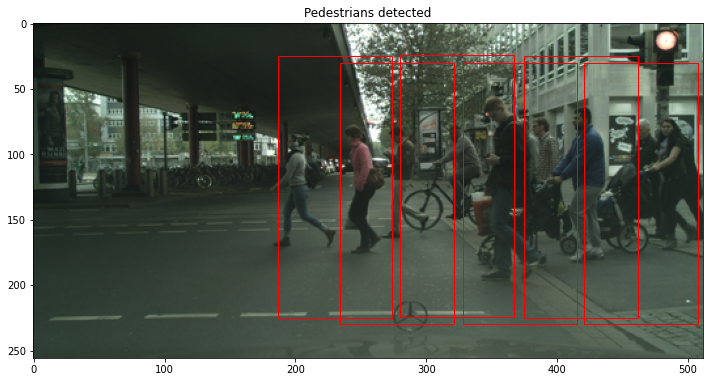

In [33]:
plt.rcParams['figure.figsize'] = [12, 8]
for i in range(3):
    detect_wrap(i)

Using more anchor boxes, we get larger training set and tighter detections. TODO: show example for 20 and then 2000.

## Video

Let's take some frames from KITTI-17 https://motchallenge.net/vis/KITTI-17

In [34]:
frames_path = '../data/sample-video-frames/'

In [35]:
## crop and scale frames
crops = []
SCALE = 1.4
for k in range(1, 18):
    img_name = 'KITTI-17-raw_' + str(k) + '.png'
    img = Image.open(frames_path + img_name)
    
    h, w = (456, 412)
    np_image = np.array(img)
    x0, y0 = 190, 40
    x1, y1 = x0 + int(w // SCALE), y0 + int(h // SCALE)
    crop = np_image[y0:y1, x0:x1]
    crop = Image.fromarray(crop, 'RGB')
    crops.append(crop)

## resize crops to W x H
newsize = (W, H)
crops = [crop.resize(newsize) for crop in crops]    

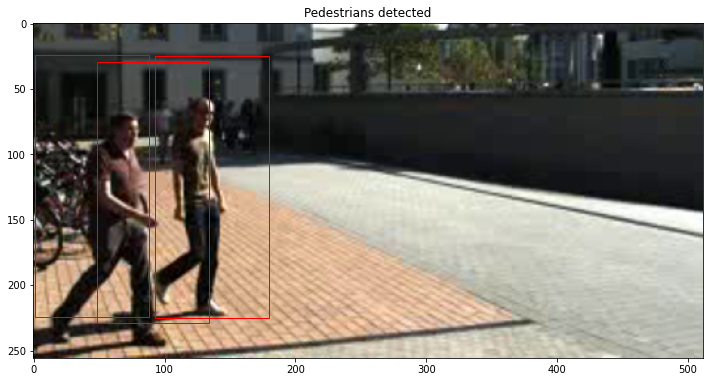

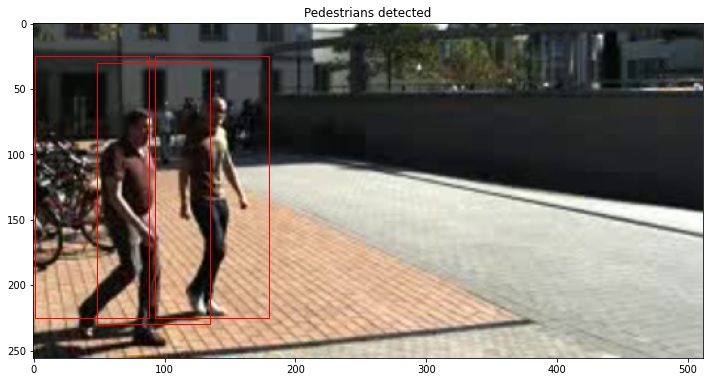

...


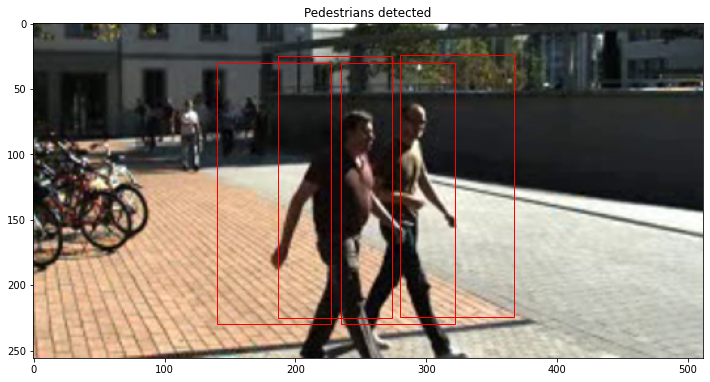

In [36]:
for k in [1,2, len(crops)-1]:
    if k > 2:
        print('...')
    detect(crops[k])

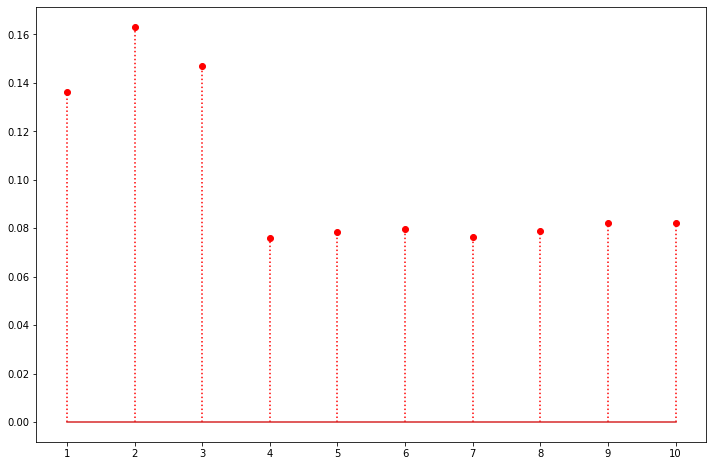

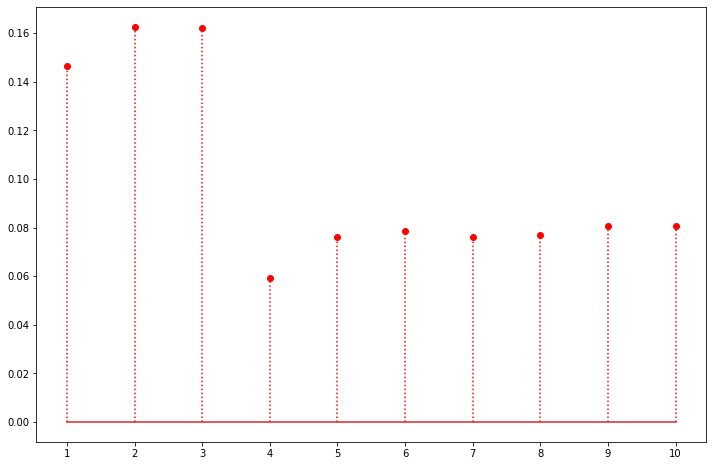

...


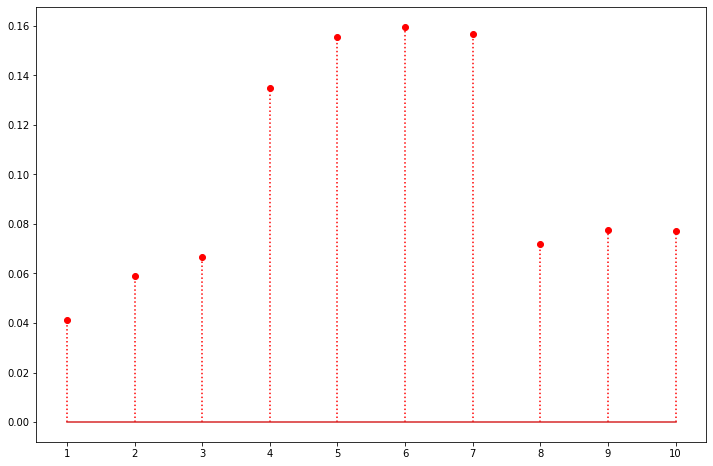

In [37]:
for k in [1,2, len(crops)-1]:
    if k > 2:
        print('...')
            
    d = detect(crops[k], show=False)
    d['confs'][np.where(d['classes'])] += 1

    rks = np.arange(1, 11)
    yks = d['confs'] / sum(d['confs']) # normalize
    markerline, stemlines, baseline = plt.stem(
        rks, yks, markerfmt='ro', label='Discretized Normal')

    plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
    plt.setp(stemlines, 'linestyle', 'dotted')
    #plt.xlabel = rks
    plt.xticks(rks, [str(rk) for rk in rks]),
    plt.show()